In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment2 import PricingEnvironment
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB

In [2]:
data_gen = BasicDataGenerator(filename='src/basic001.json')
prices = data_gen.get_prices()
bids = data_gen.get_bids()
margins = data_gen.get_margins()
conv_rates = data_gen.get_conversion_rates(mode='aggregate')
n_clicks = data_gen.get_daily_clicks(mode='aggregate')
costs_per_click = data_gen.get_costs_per_click(mode='aggregate')
aggr_tau = data_gen.get_future_purchases(mode='aggregate')

print(15*'-','DATA', '-'*15)
print(f'{prices=}')
print(f'{bids=}')
print(f'{margins=}')
print(f'{conv_rates=}')
print(f'{costs_per_click=}')
print(f'{n_clicks=}')
print(f'{aggr_tau=}')

sel_bid = 3
print(f'\nSelected bid: {bids[sel_bid]}({sel_bid})')
print(f'Fixed CPC: {costs_per_click[sel_bid]}')
print(f'Fixed num_clicks: {n_clicks[sel_bid]} -> {np.rint(n_clicks[sel_bid]).astype(int)}')
n_arms = len(prices)
env_params = {
        'n_arms': n_arms,
        'conversion_rates': conv_rates,
        'cost_per_click': costs_per_click[sel_bid],
        'n_clicks': np.rint(n_clicks[sel_bid]).astype(int),
        # 'margins': margins,
        'tau': aggr_tau
}

--------------- DATA ---------------
prices=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
bids=[0.03, 0.04, 0.07, 0.1, 0.2, 0.5, 0.75, 1.0, 1.5, 2.0]
margins=[15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
conv_rates=array([0.217, 0.214, 0.208, 0.197, 0.183, 0.164, 0.136, 0.125, 0.116,
       0.098])
costs_per_click=array([0.03 , 0.04 , 0.069, 0.097, 0.189, 0.44 , 0.627, 0.799, 1.105,
       1.375])
n_clicks=array([ 30.107,  38.897,  62.152,  81.492, 126.508, 181.541, 196.399,
       202.562, 206.463, 207.274])
aggr_tau=array([2.95, 2.58, 2.21, 1.84, 1.47, 1.1 , 0.91, 0.75, 0.7 , 0.7 ])

Selected bid: 0.1(3)
Fixed CPC: 0.097
Fixed num_clicks: 81.492 -> 81


In [3]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [4]:
opt_arm = np.argmax(margins * conv_rates * (1 + aggr_tau) - costs_per_click[sel_bid])
print(f'N_ARMS: {n_arms}')
print(f'Optimal arm: {str(opt_arm)}')

N_ARMS: 10
Optimal arm: 0


In [5]:
learners_to_test = [UCB, ThompsonSampling]
rewards_per_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []

print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')
print(f'ALGORITHMS: {list(rewards_per_experiment.keys())}')

N_ROUNDS: 365
N_EXPERIMENTS: 10
ALGORITHMS: ['UCB-Pricing', 'TS-Pricing']


In [6]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'running exp#{e}...')
    test_instances = []
    for learner in learners_to_test:
        test_instances.append((learner(arm_values=margins), PricingEnvironment(**env_params)))
    for t in range(T):
        for learner, env in test_instances:
            pulled_arm = learner.pull_arm()
            daily_reward = env.day_round(pulled_arm)
            learner.daily_update(pulled_arm, daily_reward)

    for learner, _ in test_instances:
        rewards_per_experiment[learner.LEARNER_NAME].append(learner.daily_collected_rewards)

running exp#0...
running exp#1...
running exp#2...
running exp#3...
running exp#4...
running exp#5...
running exp#6...
running exp#7...
running exp#8...
running exp#9...


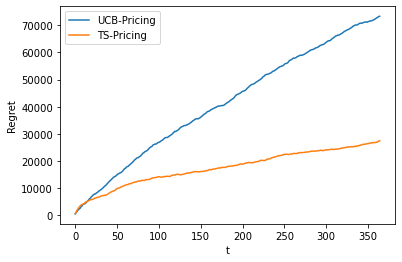

In [7]:
# Plotting the results
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
opt = (margins[opt_arm] * conv_rates[opt_arm] * (1 + aggr_tau[opt_arm]) - costs_per_click[sel_bid]) * np.rint(n_clicks[sel_bid]).astype(int)
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(rewards_per_experiment.keys())
plt.show()